In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.metrics import rand_score
import time

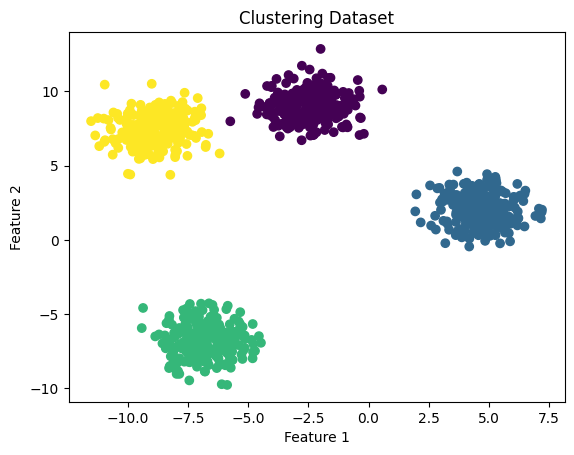

In [2]:
X, y = make_blobs(n_samples=1000, centers=4, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clustering Dataset')
plt.show()

In [3]:
def coreset(data, m):
    N = data.shape[0]
    
    mean = np.mean(data, axis=0)
    
    q = np.linalg.norm(data - mean, axis=1)**2
    sum = np.sum(q)
    q = 0.5 * (1.0/N + q/sum)
    
    samples = np.random.choice(N, m, p=q)
    coreset = data[samples]
    weights = 1.0 / (q[samples] * m)
    
    return coreset, weights 

In [4]:
def kmeans(data, weights, k, max_iterations=15):
    data = np.asarray(data)
    
    mins = data.min(axis=0)
    maxs = data.max(axis=0)
    centroids = np.random.rand(k, data.shape[1]) * (maxs - mins) + mins
    
    for _ in range(max_iterations):
        dist = cdist(data, centroids)
        weighted_dist = dist * weights[:, np.newaxis]
        labels = np.argmin(weighted_dist, axis=1)
        
        for j in range(k):
            cluster = labels == j
            if weights[cluster].sum() > 0:
                centroids[j] = np.average(data[cluster], axis=0, weights=weights[cluster])
            else:
                centroids[j] = np.random.rand(1, data.shape[1]) * (maxs - mins) + mins
    
    return centroids


def predict(data, centroids):
    dist = cdist(data, centroids)
    labels = np.argmin(dist, axis=1)
    return labels

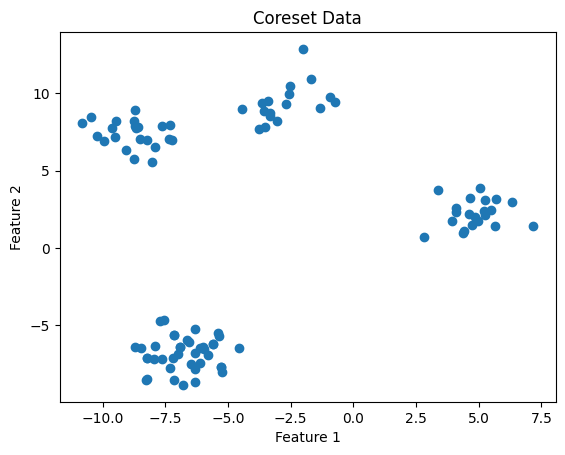

In [5]:
data_coreset, data_weights = coreset(X, 100)
plt.scatter(data_coreset[:, 0], data_coreset[:, 1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Coreset Data')
plt.show()


In [6]:
data_weights

array([ 7.00342399,  7.97135551,  9.91758005, 12.1774561 , 10.80952394,
       11.86009797, 11.02944885,  8.34608452, 12.12368685, 12.17995944,
        6.03381966, 10.06732161,  9.02985522, 11.52379184,  9.64773938,
       12.53596522, 13.58812167, 10.1465511 , 10.00890014,  7.28048559,
        8.96253714,  6.29748983,  6.05841259, 14.05752478,  8.56551101,
       14.73577421,  9.49930691,  9.71660198,  7.37726834, 13.40005155,
        9.43470877, 10.62412988, 10.21680675, 11.34846084,  9.46277567,
        7.03872764, 12.28339497,  9.20870161,  7.8688335 , 10.91595729,
       13.29077904,  7.00342399, 10.36589249, 10.89065287,  6.40002475,
       12.14562451,  7.28048559, 13.33989563,  8.89363957,  7.36357183,
        8.04344964,  8.33822407, 13.06077865,  9.40809264, 10.14325358,
        7.61085576, 10.25683985,  8.63198065, 10.24024765,  8.98019985,
       10.16777464,  7.20658979,  7.3324977 , 12.02619765,  8.48149708,
       11.40507172,  9.50907381,  6.98798051, 10.90504501,  6.80

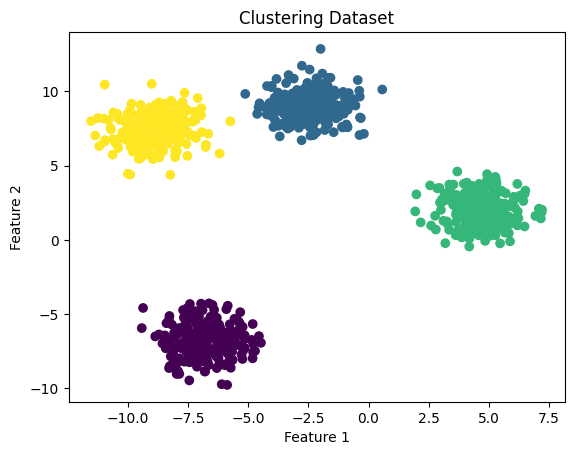

In [7]:
centroids_coreset = kmeans(data_coreset, data_weights, 4, 15)
labels_coreset = predict(X, centroids_coreset)

plt.scatter(X[:, 0], X[:, 1], c=labels_coreset)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clustering Dataset')
plt.show()

In [8]:
from keras.datasets import mnist
import numpy as np

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

test_images_vector = test_images.reshape(test_images.shape[0], -1)
train_images_vector = train_images.reshape(train_images.shape[0], -1)

print(np.shape(test_images_vector))
print(np.shape(train_images_vector))

(10000, 784)
(60000, 784)


In [9]:
image_coreset, image_weights = coreset(train_images_vector, 1000)
image_coreset.shape

(1000, 784)

In [10]:
tic = time.time()
image_centroids = kmeans(train_images_vector, np.ones(train_images_vector.shape[0]), 10, 100)
image_labels = predict(test_images_vector, image_centroids)
rand_index = rand_score(test_labels, image_labels)
print(f"Rand index: {rand_index}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Rand index: 0.8778292829282929
Execution Time: 46.81163573265076


In [11]:
tic = time.time()
image_coreset_centroids = kmeans(image_coreset, image_weights, 10, 100)
image_labels = predict(test_images_vector, image_coreset_centroids)
rand_index = rand_score(test_labels, image_labels)
print(f"Rand index: {rand_index}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Rand index: 0.8753891189118912
Execution Time: 0.7045814990997314


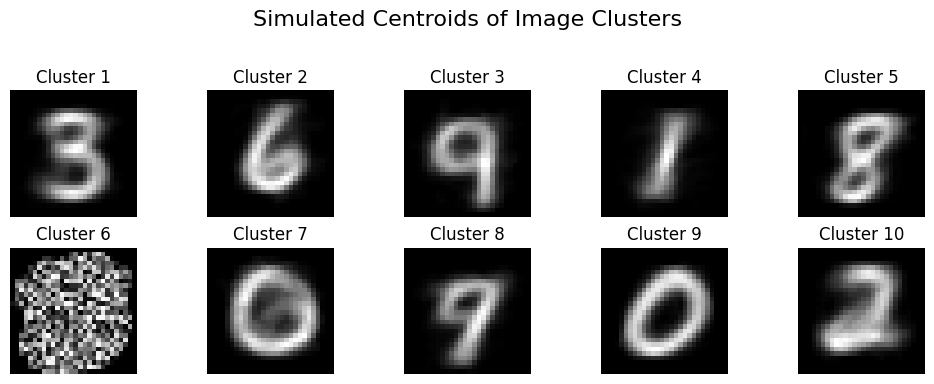

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
fig.suptitle('Simulated Centroids of Image Clusters', fontsize=16)
for i, ax in enumerate(axs.flat):
    ax.imshow(image_coreset_centroids[i].reshape(28,28), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Cluster {i+1}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


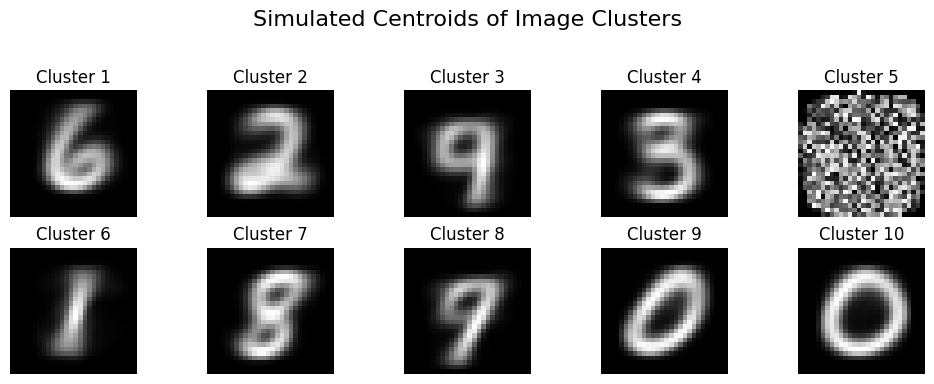

In [13]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
fig.suptitle('Simulated Centroids of Image Clusters', fontsize=16)
for i, ax in enumerate(axs.flat):
    ax.imshow(image_centroids[i].reshape(28,28), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Cluster {i+1}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()